In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [16]:
semantic_engine = create_engine('sqlite:///semantic.db', echo = False)
semantic_conn = semantic_engine.connect()

,Country,revenue
0,FRANCE,2.890088e+11
1,INDONESIA,2.882849e+11
2,RUSSIA,2.879117e+11
3,MOZAMBIQUE,2.868597e+11
4,JORDAN,2.861869e+11


<AxesSubplot: title={'center': 'Top 5 Countries by revenue'}, xlabel='Country'>

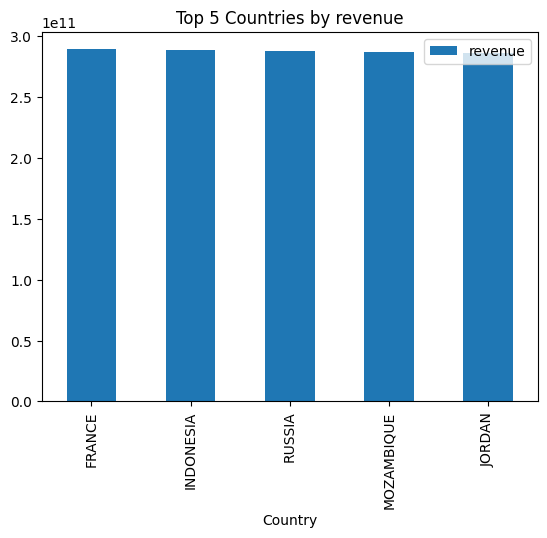

In [17]:
query = """
SELECT 
C.n_name AS Country, SUM(net_revenue) AS revenue
FROM fact_lineitem A
LEFT JOIN dim_customer B ON A.custkey = B.c_custkey
LEFT JOIN dim_nation C ON B.c_nationkey = C.n_nationkey
GROUP BY C.n_name
ORDER BY SUM(net_revenue) DESC
LIMIT 5
;
"""

df = pd.read_sql(query, semantic_conn)
display(df)
df.plot(kind = 'bar', x = "Country", title="Top 5 Countries by revenue")

,shipmode,num_orders
0,SHIP,175765
1,MAIL,175530
2,TRUCK,175387
3,AIR,175217
4,REG AIR,175040
5,FOB,174782
6,RAIL,174766


<AxesSubplot: xlabel='shipmode'>

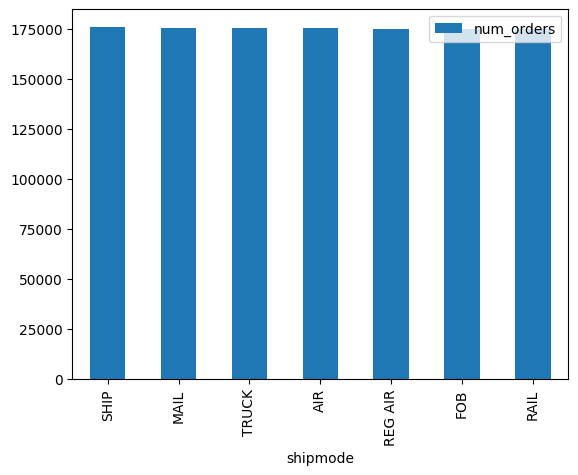

In [22]:
query  = """
WITH top_5_nations AS (
SELECT 
C.n_name
FROM fact_lineitem A
LEFT JOIN dim_customer B ON A.custkey = B.c_custkey
LEFT JOIN dim_nation C ON B.c_nationkey = C.n_nationkey
GROUP BY C.n_name
ORDER BY SUM(net_revenue) DESC
LIMIT 5
)

SELECT shipmode, COUNT(*) num_orders
FROM fact_lineitem A
LEFT JOIN dim_customer B ON A.custkey = B.c_custkey
LEFT JOIN dim_nation C ON B.c_nationkey = C.n_nationkey
WHERE C.n_name IN (SELECT D.n_name FROM top_5_nations D)
GROUP BY shipmode
ORDER BY COUNT(*) DESC
"""

df = pd.read_sql(query, semantic_conn)
display(df)
df.plot(kind = 'bar', x = "shipmode")


,month,revenue
0,01,6.355499e+11
1,07,6.340635e+11
2,03,6.319460e+11
3,05,6.318242e+11
4,06,6.166014e+11
5,04,6.153189e+11
6,02,5.746841e+11
7,08,5.503113e+11
8,12,5.488266e+11
9,10,5.423671e+11


<AxesSubplot: xlabel='month'>

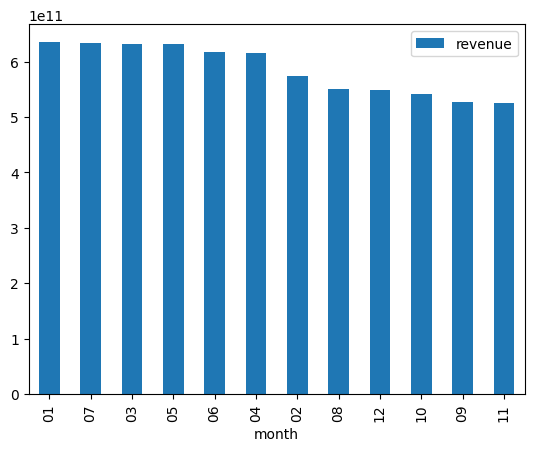

In [19]:
query = """
SELECT 
B.month, SUM(net_revenue) AS revenue
FROM fact_lineitem A
LEFT JOIN dim_date B ON A.order_date_skey = B.date_skey
GROUP BY B.month
ORDER BY SUM(net_revenue) DESC
;
"""

df = pd.read_sql(query, semantic_conn)

display(df)
df.plot(kind = 'bar', x = "month")

In [23]:
query = f"""
WITH top_10_revenue AS (
SELECT 
"By Revenue" AS Measure, B.c_name, SUM(net_revenue) AS Total
FROM fact_lineitem A
LEFT JOIN dim_customer B ON A.custkey = B.c_custkey
GROUP BY "By Revenue", B.c_name
ORDER BY SUM(net_revenue) DESC
LIMIT 10
)
,top_10_quantity AS (
SELECT "By Quantity" AS Measure, B.c_name, SUM(quantity) AS Total
FROM fact_lineitem A
LEFT JOIN dim_customer B ON A.custkey = B.c_custkey
GROUP BY "By Quantity", B.c_name
ORDER BY SUM(quantity) DESC
LIMIT 10
)
SELECT * FROM top_10_revenue
UNION ALL
SELECT * FROM top_10_quantity
"""
df = pd.read_sql(query, semantic_conn)

display(df)

,Measure,c_name,Total
0,By Revenue,Customer#000143500,2.236875e+08
1,By Revenue,Customer#000095257,2.155614e+08
2,By Revenue,Customer#000131113,2.091192e+08
3,By Revenue,Customer#000134380,2.049092e+08
4,By Revenue,Customer#000028180,2.028063e+08
5,By Revenue,Customer#000053809,2.011917e+08
6,By Revenue,Customer#000087115,2.003277e+08
7,By Revenue,Customer#000103834,2.001468e+08
8,By Revenue,Customer#000102022,1.999926e+08
9,By Revenue,Customer#000064660,1.992855e+08


,Quarter,revenue
0,FY2020 Q2,2.465679e+11
1,FY2021 Q1,8.075899e+11
2,FY2021 Q2,8.070410e+11
3,FY2021 Q3,7.885015e+11
4,FY2021 Q4,8.014518e+11
5,FY2022 Q1,9.039935e+11
6,FY2022 Q2,5.629672e+11
7,FY2022 Q3,1.053678e+12
8,FY2022 Q4,1.062293e+12


<AxesSubplot: xlabel='Quarter'>

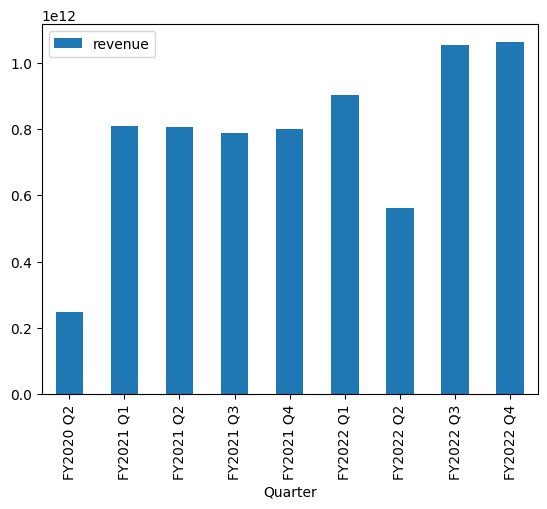

In [21]:
query = """
SELECT 
"FY" ||
CASE 
    WHEN B.year >= 7 THEN B.year + 1
    ELSE B.year
    END
|| " Q" ||
    CASE 
    WHEN B.month IN ("01", "02", "03") THEN "3"
    WHEN B.month IN ("04", "05", "06") THEN "4"
    WHEN B.month IN ("07", "08", "09") THEN "1"
    WHEN B.month IN ("10", "11", "12") THEN "2"
    ELSE ""
    END
 AS Quarter
,SUM(net_revenue) AS revenue
FROM fact_lineitem A
LEFT JOIN dim_date B ON A.order_date_skey = B.date_skey
GROUP BY 
"FY" ||
CASE 
    WHEN B.year >= 7 THEN B.year + 1
    ELSE B.year
    END
 

|| " Q" ||
    CASE 
    WHEN B.month IN ("01", "02", "03") THEN "3"
    WHEN B.month IN ("04", "05", "06") THEN "4"
    WHEN B.month IN ("07", "08", "09") THEN "1"
    WHEN B.month IN ("10", "11", "12") THEN "2"
    ELSE ""
    END
ORDER BY 
"FY" ||
CASE 
    WHEN B.year >= 7 THEN B.year + 1
    ELSE B.year
    END

|| " Q" ||
    CASE 
    WHEN B.month IN ("01", "02", "03") THEN "3"
    WHEN B.month IN ("04", "05", "06") THEN "4"
    WHEN B.month IN ("07", "08", "09") THEN "1"
    WHEN B.month IN ("10", "11", "12") THEN "2"
    ELSE ""
    END


"""
df = pd.read_sql(query, semantic_conn)

display(df)
df.plot(kind = 'bar', y = "revenue", x = "Quarter")